In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations

import matplotlib.pyplot as plt

### Data

In [2]:
from scipy.stats import pearsonr
import seaborn as sns
from random import sample, seed

In [3]:
working_dir = 'tmp/'

# File inputs
# x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x_input = 'data/train_protein_matrix.csv'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

test_input = 'data/test_protein_matrix.csv'

interaction_input = 'tmp/final3_aux.tsv'


In [4]:
x = pd.read_csv(x_input)

y = pd.read_csv(y_input, usecols=['drug_id','cell_line_name','ln_IC50', 'max_screening_conc'])
y = y[[c for c in y if c != 'ln_IC50'] + ['ln_IC50']]

print("loading data:", test_input)
x_test = pd.read_csv(test_input)

loading data: data/test_protein_matrix.csv


In [5]:
tested_regression = pd.read_csv(interaction_input, sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])

C:\Users\wen068\AppData\Local\Temp\ipykernel_17460\2839908837.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tested_regression = pd.read_csv(interaction_input, sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])


In [6]:
tested_mask = tested_regression.order == tested_regression.coef_id.str.count(":")+1
interactions = tested_regression[tested_mask]

In [7]:
drug_list = np.unique(interactions.drug)

### Regression

#### Functions

In [8]:
def results_fit_to_df(results, ols, y, test_data):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    pred_y = results.predict()
    train_pear_R = pearsonr(pred_y, y)
    train_mse = np.square(y - pred_y).mean()

    test_y = test_data.lnICfa.to_list()
    pred_y = results.predict(test_data)
    test_pear_R = pearsonr(pred_y, test_y)
    test_mse = np.square(test_y - pred_y).mean()

    
    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    results['adj_r2'] = adj_r2
    results["train_MSE"] = train_mse
    results["MSE"] = test_mse
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    results["train_pearsonR"] = train_pear_R.statistic
    results["pearsonR"] = test_pear_R.statistic
    return results

In [9]:
def regression_per_drug(interactions, drug_list, alpha=0.05, filter=0):
    final_results = []
    j = 0
    for i,d in enumerate(drug_list):
        xy = x.merge(y[y["drug_id"]==d], left_on='Cell_Line', right_on='cell_line_name')
        xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns] 

        test_xy = x_test.merge(y[y["drug_id"] == d], left_on='Cell_Line', right_on='cell_line_name')
        test_xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x_test.replace('_','').replace('.','')]) for x_test in test_xy.columns] 
        
        drug_interactions = interactions[interactions.drug == d].drop_duplicates(ignore_index=True)
        sig = fdrcorrection(drug_interactions["P>|z|"], alpha=alpha, method='indep', is_sorted=False)[0]
        
        drug_interactions = drug_interactions[sig]
        sig_interactions = drug_interactions[np.abs(drug_interactions.coef)>=filter][["coef_id", "order"]]
        # sig_interactions["coef_id"] = sig_interactions["coef_id"].str.strip("\[01\]")
        protein_list = np.unique([y for x in sig_interactions.coef_id for y in x.split(":")]).tolist()  # all proteins used in significant synergies of that drug
        print("for drug", d, "reduced from", drug_interactions.shape[0], "to", sig_interactions.shape[0], "with", len(protein_list), "proteins")
        
        data = xy[["lnICfa", "maxscreeningconc"] + protein_list].fillna(0)
        test_data = test_xy[["lnICfa", "maxscreeningconc"] + protein_list].fillna(0)
        print(test_data.shape, data.shape)
        del xy, test_xy
        # with each interration add more interaction information to the regression formula
        for o in [1,2,5]:
            # print("Order: ", o)
            excluded = sig_interactions.coef_id[sig_interactions.order<=o].drop_duplicates(ignore_index=True).to_list() + protein_list
            included = []
            print("number of possible variables:", len(excluded))
            seed(42)
            while excluded:
                p_vals = []
                sub_set = [excluded[i] for i in sample(range(len(excluded)), np.min([200, len(excluded)]))] # maybe increase to 500?
                for variable in sub_set:
                    formular = "lnICfa" + " ~ maxscreeningconc + "
                    formular = formular + " + ".join(included + [variable])
            
                    results = smf.ols(formular, data=data).fit(disp=False, maxiter=1000)
                    p_vals.append(results.pvalues[variable])
                best_p = np.min(p_vals)
                if best_p < alpha:
                    i = np.argmin(p_vals)
                    # print('Add {} with p-value {}'.format(sub_set[i], best_p))
                    included.append(sub_set[i])
                    excluded.remove(sub_set[i])
                else:
                    print(best_p)
                    break
                # backward
                formular = "lnICfa" + " ~ maxscreeningconc + "
                formular = formular + " + ".join(included)
                results = smf.ols(formular, data=data).fit(disp=False, maxiter=1000)
                worst_p = np.max(results.pvalues)
                i = np.argmax(results.pvalues) - 2  #  (intercept and maxscreen)
                if i <= 0: continue
                if worst_p > alpha:
                    # print('Remove {} with p-value {}'.format(included[i], worst_p))
                    del included[i]
            formular = "lnICfa" + " ~ maxscreeningconc + "
            formular = formular + " + ".join(included)
            
            try:
                ols = smf.ols(formular,data=data)
            except Exception as inst:
                print(type(inst))
                print('error in OLS, drug', d, "order: ", o, "number of variables (+)", formular.count('+') )
                print(sig_interactions.shape, len(protein_list))
                j += 1
                
                break  # we do not need to check any higher order, if the lower order already fails due to recursion depth
            ols.raise_on_perfect_prediction = False #preventing the perfect separation error
            results = ols.fit(maxiter=100) #method prevents singular matrix
            results = results_fit_to_df(results, ols, data["lnICfa"].to_list(), test_data)
            results["order"] = o
            results["drug"] = d
            results["n_prot"] = len(protein_list) 
            results["n_obs"] = len(data.lnICfa)
            results["n_feat"] = len(included)
            final_results.append(results)
    final_results = pd.concat(final_results)
    print(j/(len(drug_list)), " % of drugs failed OLS at some point")        
    print("The largest amount of features used for a regression was: ", final_results.n_feat.max())
    return final_results

#### Results

In [55]:
len(coef_05[["drug"]].drop_duplicates()), len(drug_list)

(75, 79)

Drugs with error/ols problems: 233, 273, 333, 1003, 1013

In [12]:
coef_05 = regression_per_drug(interactions, [233, 273, 333, 1003, 1013, 1403], filter=0.5)

for drug 233 reduced from 0 to 0
(0, 2) (0, 2)
number of possible variables: 0
<class 'patsy.PatsyError'>
error in OLS, drug 233 order:  1 number of variables (+) 1
(0, 2) 0
for drug 273 reduced from 2907 to 751
(174, 821) (688, 821)
number of possible variables: 819
Add QgJBYjCPZIPHUMAN with p-value 2.1402325728786978e-23
Add QbdfabSQSTMHUMAN with p-value 1.0993686886898683e-07
Add QabaifTIARHUMAN with p-value 0.00019776894059048402
Add PbhieeDDXfHUMAN with p-value 0.0008323237594248853
Add QbfaegSYKHUMAN with p-value 0.0009602912549955414
Add PedbffCACPHUMAN with p-value 0.0016237961629957628
Add PajgabHMOXbHUMAN with p-value 0.00440873907248608
Add OaaebbRPOMHUMAN with p-value 0.018452174461511976
Add QbdgbiCULdHUMAN with p-value 0.0002920452223402934
Add OhfbhfCNOTdHUMAN with p-value 0.009363385783723659
Add QiNfKbCISDcHUMAN with p-value 0.009737985937067806
Add QjYcHfPKHAgHUMAN with p-value 0.0054563271446605
Add QjgKRbZFRHUMAN with p-value 0.009407217278716504
Add PcdhigCPTcHUMAN

In [18]:
coef_05[["adj_r2", "pseudo_r2", 'train_MSE', 'MSE', 'pearsonR', 'train_pearsonR', 'drug', 'n_prot']].drop_duplicates(ignore_index=True)

,adj_r2,pseudo_r2,train_MSE,MSE,pearsonR,train_pearsonR,drug,n_prot
0,NaN,1.000000,3.741299e-27,19.797882,0.113822,1.000000,273,819
1,0.482801,0.833995,1.707295e-01,2.647130,0.264800,0.913233,333,476
2,NaN,1.000000,1.944908e-26,6.842633,0.058441,1.000000,333,476
3,NaN,1.000000,8.996787e-28,9.352385,0.351122,1.000000,1003,1095
4,0.258834,0.399111,5.636250e-01,0.620222,0.370182,0.631753,1403,134
5,0.505561,0.700404,2.810171e-01,0.753289,0.318975,0.836901,1403,134


In [14]:
coef_05[["adj_r2", "pseudo_r2", 'train_MSE', 'MSE', 'pearsonR', 'train_pearsonR', 'drug', 'n_prot', 'n_feat']].drop_duplicates(ignore_index=True)

,adj_r2,pseudo_r2,train_MSE,MSE,pearsonR,train_pearsonR,drug,n_prot,n_feat
0,0.440956,0.480830,1.496254,3.480606,0.389147,0.693419,273,819,49
1,0.405101,0.437141,1.622168,3.243513,0.427625,0.661166,273,819,37
2,0.473284,0.492820,0.521614,0.938894,0.609285,0.702011,333,476,26
3,0.534393,0.557640,0.454949,0.935667,0.612583,0.746753,333,476,35
4,0.588996,0.613493,1.316103,2.269017,0.617643,0.783258,1003,1095,45
5,0.641238,0.670700,1.121308,2.237964,0.630616,0.818962,1003,1095,62
6,0.605547,0.627014,0.978553,2.120635,0.544671,0.791842,1013,1922,79
7,0.623158,0.639565,0.945623,2.167400,0.539388,0.799728,1013,1922,63
8,0.275463,0.300024,0.656568,0.564155,0.353863,0.547744,1403,134,24
9,0.478068,0.500921,0.468129,0.514587,0.368566,0.707758,1403,134,31


In [18]:
baseline[baseline.coef_id.apply(lambda x: x.count(':') > 1)].groupby('drug').size()

drug
1013    1
1403    2
dtype: int64

In [17]:
baseline[["adj_r2", "pseudo_r2", 'train_MSE', 'MSE', 'pearsonR', 'train_pearsonR', 'drug', 'n_prot', 'n_feat']].drop_duplicates(ignore_index=True)

,adj_r2,pseudo_r2,train_MSE,MSE,pearsonR,train_pearsonR,drug,n_prot,n_feat
0,0.304759,0.319939,1.959945,3.308916,0.384415,0.565631,273,1829,15
1,0.402053,0.428165,1.648037,3.532231,0.384187,0.654343,273,1829,30
2,0.751704,0.789249,0.216748,1.212628,0.531187,0.888397,333,2904,106
3,0.713929,0.742903,0.264413,1.055163,0.578875,0.861918,333,2904,71
4,0.686508,0.713497,0.975577,2.514291,0.611965,0.844688,1003,2285,65
5,0.692641,0.715846,0.967579,2.542299,0.593101,0.846077,1003,2285,57
6,0.630150,0.653800,0.908277,2.063076,0.561102,0.808579,1013,4075,93
7,0.627003,0.644257,0.933313,2.464115,0.471706,0.802656,1013,4075,67
8,0.430898,0.473500,0.493850,0.649110,0.365665,0.688113,1403,563,53
9,0.624052,0.654319,0.324244,0.641325,0.285963,0.808900,1403,563,57


In [12]:
coef_05.to_csv(working_dir+"coef_05.csv", index=False)

<Axes: xlabel='n_prot', ylabel='pseudo_r2'>

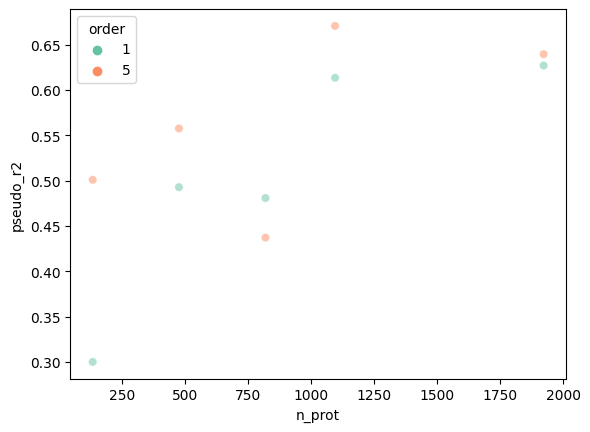

In [15]:
sns.scatterplot(data=coef_05[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="pseudo_r2", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_feat', ylabel='pearsonR'>

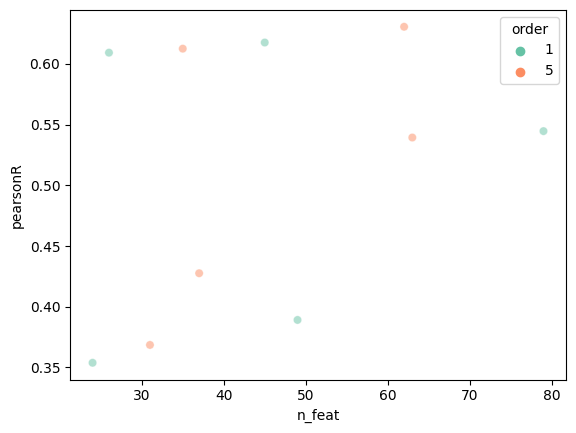

In [18]:
sns.scatterplot(data=coef_05[["pearsonR", "adj_r2", "pseudo_r2", "order", "n_prot", "n_feat"]].drop_duplicates(ignore_index=True), x="n_feat", y="pearsonR", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_prot', ylabel='adj_r2'>

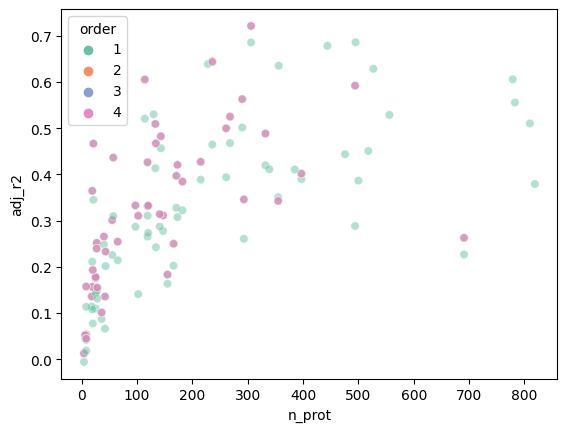

In [34]:
# adj includes nan if to few observations for amount of variables
sns.scatterplot(data=coef_05[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="adj_r2", hue="order", palette="Set2", alpha=0.5) 

In [11]:
baseline = regression_per_drug(interactions, [233, 273, 333, 1003, 1013, 1403])

for drug 233 reduced from 0 to 0 with 0 proteins
(0, 2) (0, 2)
number of possible variables: 0
<class 'patsy.PatsyError'>
error in OLS, drug 233 order:  1 number of variables (+) 1
(0, 2) 0
for drug 273 reduced from 2907 to 2907 with 1829 proteins
(174, 1831) (688, 1831)
number of possible variables: 1829
0.05902104756116065
number of possible variables: 4736
0.06881810027185475
for drug 333 reduced from 9151 to 9151 with 2904 proteins
(175, 2906) (702, 2906)
number of possible variables: 2904
0.05018085354024315
number of possible variables: 12055
0.054965987242865014
for drug 1003 reduced from 4140 to 4140 with 2285 proteins
(188, 2287) (756, 2287)
number of possible variables: 2285
0.05686170598258353
number of possible variables: 6425
0.06155112458206418
for drug 1013 reduced from 31476 to 31476 with 4075 proteins
(368, 4077) (1471, 4077)
number of possible variables: 4075
0.06585040062052018
number of possible variables: 35551
0.06493751409750335
for drug 1403 reduced from 701 to 

In [28]:
len(baseline[["drug"]].drop_duplicates())

52

In [14]:
baseline.to_csv(working_dir+"baseline.csv", index=False)

In [12]:
coef_05["batch"] = "|Coef| > 0.5"
baseline["batch"] = "baseline"

combined = pd.concat([coef_05, baseline], ignore_index=True)
combined = combined[["MSE", "pearsonR", "order", "drug", "batch"]].drop_duplicates(ignore_index=True)
sns.violinplot(data=combined, x="MSE", y="order", hue="batch", cut=0, orient="h" )
# plt.savefig(working_dir+"img/mse.png")

NameError: name 'coef_05' is not defined